### Name - Rakesh Ravi K U
### Computing ID - rk9cx
### PySpark Machine Learning Assignment 1

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

## Initializing Environment

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

## Reading Files

In [4]:
import pandas as pd
import chardet
with open('data.csv', 'rb') as f:
    result = chardet.detect(f.read())

In [5]:
#reading dataframe
role = get_execution_role()
path='/home/ec2-user/SageMaker/rk9cx/data.csv'
pddf = pd.read_csv(path, encoding=result['encoding'])
pddf.dropna(inplace=True)
pddf.head()

,D,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [6]:
pddf.columns = ["Decision","city_services","housing_cost","school_quality","trust_in_police",
                "maintenance","community_events"]
pddf.head()

,Decision,city_services,housing_cost,school_quality,trust_in_police,maintenance,community_events
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [7]:
#creating spark dataframe
df = sqlc.createDataFrame(pddf)
df

DataFrame[Decision: bigint, city_services: bigint, housing_cost: bigint, school_quality: bigint, trust_in_police: bigint, maintenance: bigint, community_events: bigint]

In [ ]:
# Write parquet to temporary location
parquetPath = '/home/ec2-user/SageMaker/rk9cx/temp-prqt'
df.write.parquet(parquetPath)

In [9]:
# Reading Parquet file back in
df2 = sqlc.read.parquet(parquetPath)
df2

DataFrame[Decision: bigint, city_services: bigint, housing_cost: bigint, school_quality: bigint, trust_in_police: bigint, maintenance: bigint, community_events: bigint]

In [10]:
#printing Schema
df2.printSchema()

root
 |-- Decision: long (nullable = true)
 |-- city_services: long (nullable = true)
 |-- housing_cost: long (nullable = true)
 |-- school_quality: long (nullable = true)
 |-- trust_in_police: long (nullable = true)
 |-- maintenance: long (nullable = true)
 |-- community_events: long (nullable = true)



In [11]:
# First five rows
df2.take(5)

[Row(Decision=0, city_services=3, housing_cost=3, school_quality=3, trust_in_police=4, maintenance=2, community_events=4),
 Row(Decision=0, city_services=3, housing_cost=2, school_quality=3, trust_in_police=5, maintenance=4, community_events=3),
 Row(Decision=1, city_services=5, housing_cost=3, school_quality=3, trust_in_police=3, maintenance=3, community_events=5),
 Row(Decision=0, city_services=5, housing_cost=4, school_quality=3, trust_in_police=3, maintenance=3, community_events=5),
 Row(Decision=0, city_services=5, housing_cost=4, school_quality=3, trust_in_police=3, maintenance=3, community_events=5)]

## Exploratory Data Analysis

In [12]:
print("Pearson's r(Decision,city_services) = {}".format(df2.corr("Decision", "city_services")))
print("Pearson's r(Decision,housing_cost) = {}".format(df2.corr("Decision", "housing_cost")))
print("Pearson's r(Decision,school_quality) = {}".format(df2.corr("Decision", "school_quality")))
print("Pearson's r(Decision,trust_in_police) = {}".format(df2.corr("Decision", "trust_in_police")))
print("Pearson's r(Decision,maintenance) = {}".format(df2.corr("Decision", "maintenance")))
print("Pearson's r(Decision,community_events) = {}".format(df2.corr("Decision", "community_events")))

Pearson's r(Decision,city_services) = 0.3127395156019425
Pearson's r(Decision,housing_cost) = 0.019368282262486183
Pearson's r(Decision,school_quality) = 0.16363887368660246
Pearson's r(Decision,trust_in_police) = 0.11335631885726657
Pearson's r(Decision,maintenance) = 0.20668503239755812
Pearson's r(Decision,community_events) = 0.22072863286213648


## Train-Test Splitting

In [13]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df2.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 112, test set N = 31


## Vectorizing

In [15]:
from pyspark.ml.linalg import Vectors, VectorUDT # nb: bad form, done for pedagogy

In [15]:
from pyspark.ml.linalg import Vectors, VectorUDT

# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("Decision", "oneElementVec(school_quality) as school_quality")
testDF = testDF.selectExpr("Decision", "oneElementVec(school_quality) as school_quality")

print(trainingDF.orderBy(trainingDF.school_quality.desc()).limit(5))

DataFrame[Decision: bigint, school_quality: vector]


In [16]:
# Renaming columns for happiness
trainingDF = trainingDF.withColumnRenamed("Decision", "label").withColumnRenamed("school_quality", "features")
testDF = testDF.withColumnRenamed("Decision", "label").withColumnRenamed("school_quality", "features")

## Modelling : Logistic Regression

In [ ]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [17]:
from pyspark.ml.classification import *

lr = LogisticRegression()
lrModel = lr.fit(trainingDF)

In [18]:
type(lrModel)

pyspark.ml.classification.LogisticRegressionModel

In [19]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=1, features=DenseVector([3.0]), rawPrediction=DenseVector([-0.1699, 0.1699]), probability=DenseVector([0.4576, 0.5424]), prediction=1.0), Row(label=1, features=DenseVector([3.0]), rawPrediction=DenseVector([-0.1699, 0.1699]), probability=DenseVector([0.4576, 0.5424]), prediction=1.0), Row(label=1, features=DenseVector([2.0]), rawPrediction=DenseVector([0.1565, -0.1565]), probability=DenseVector([0.539, 0.461]), prediction=0.0), Row(label=1, features=DenseVector([3.0]), rawPrediction=DenseVector([-0.1699, 0.1699]), probability=DenseVector([0.4576, 0.5424]), prediction=1.0), Row(label=1, features=DenseVector([3.0]), rawPrediction=DenseVector([-0.1699, 0.1699]), probability=DenseVector([0.4576, 0.5424]), prediction=1.0)]


## Modelling Evaluation

In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation (areaUnderROC|areaUnderPR) (default: areaUnderROC)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)


In [21]:
eval.setMetricName("areaUnderROC").evaluate(predictionsAndLabelsDF)

0.6050420168067225

In [22]:
eval.setMetricName("areaUnderPR").evaluate(predictionsAndLabelsDF)

0.5807928630509275

## Visualization - ROC Curve

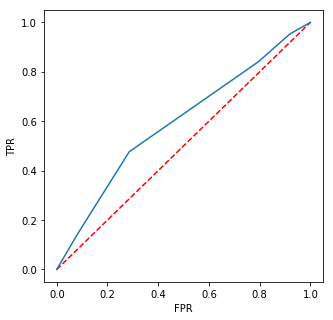

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lrModel.summary.roc.select('FPR').collect(),
         lrModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()